# Import packages and dataset

In [1]:
## Data manipulation
import pandas as pd
import numpy as np
import pyrsm as rsm
import os
import glob
import re
import warnings
warnings.filterwarnings("ignore")

## Sklearn module
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import (
    GridSearchCV, 
    cross_val_score, 
    train_test_split,
    ShuffleSplit
)
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

## Language Processing
# NLTK module
import nltk
from nltk.tokenize import word_tokenize as wt
from nltk.tokenize import sent_tokenize as st
from nltk.stem import PorterStemmer 
from nltk.corpus import stopwords
# Jieba module
import jieba


## Graphing
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns
# increase plot resolution and set font
matplotlib.font_manager.fontManager.addfont('STHeitiSC-Medium-02.ttf')
%matplotlib inline
plt.rcParams["figure.dpi"] = 130
plt.rcParams['font.family'] = ['Heiti SC']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
df = pd.read_excel('nike_basketball.xlsx', sheet_name = 0)
df.head(5).transpose()

,0,1,2,3,4
DOCID,news:05i9^202003224263017(S:435067812),NaN,news:05i9^202003224263017(S:435067812),NaN,NaN
PUBTYPE,app,NaN,app,NaN,NaN
SOURCE,看点快报 APP,NaN,看点快报 APP,NaN,NaN
PUBLISHDATE,21/3/2020 16:00:00,NaN,21/3/2020 16:00:00,NaN,NaN
AUTHOR,科比系列,NaN,科比系列,NaN,NaN
SECTION,天天快报,NaN,天天快报,NaN,NaN
WORDCOUNT,193.0,NaN,193.0,NaN,NaN
HEADLINE,"NIKE LEBRON 17 ""COMMAND FORCE"" 实物首度曝光",NaN,"NIKE LEBRON 17 ""COMMAND FORCE"" 实物首度曝光",NaN,NaN
SENTENCE,'LeBron 系列再度致敬 Nike 旗下经典鞋款我们可以经常看到 Nike 在近年的 L...,NaN,"'据悉，这双Nike LeBron 17 ""Command Force""将会在今年晚些时候...",NaN,NaN
RELEVANT,1.0,NaN,1.0,NaN,NaN


In [ ]:
df.tail(5).transpose()

# EDA

In [ ]:
## take a look of the whole data set's information
df.info()

##### We can see the data set has missing values, and some column's datatype is not correct. Before heading into the EDA, we need to filter some useless rows, fill N/A value, and change some column's data type

In [3]:
## Filter rows with DOCID is NaN
df_clean = df[df.DOCID.notnull()]

## Fill NaN for each Column
df_clean.loc[:, 'AUTHOR'] = df_clean.loc[:, 'AUTHOR'].fillna('Missing Author')
df_clean.loc[:, 'SECTION'] = df_clean.loc[:, 'SECTION'].fillna('Missing Section')
df_clean.loc[:, 'INDICATORWORD'] = df_clean.loc[:, 'INDICATORWORD'].fillna('Missing Indicator')

## Define column to correct data type
df_clean['PUBLISHDATE'] = pd.to_datetime(df_clean['PUBLISHDATE'])
df_clean['PUBTYPE'] = df_clean['PUBTYPE'].astype(str)
df_clean['RELEVANT'] = df_clean['RELEVANT'].astype(str)

## Chcek data set's information again
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1087 entries, 0 to 4141
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DOCID          1087 non-null   object        
 1   PUBTYPE        1087 non-null   object        
 2   SOURCE         1087 non-null   object        
 3   PUBLISHDATE    1087 non-null   datetime64[ns]
 4   AUTHOR         1087 non-null   object        
 5   SECTION        1087 non-null   object        
 6   WORDCOUNT      1087 non-null   float64       
 7   HEADLINE       1087 non-null   object        
 8   SENTENCE       1087 non-null   object        
 9   RELEVANT       1087 non-null   object        
 10  INDICATORWORD  1087 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(9)
memory usage: 101.9+ KB


In [ ]:
## Check data set's basic statistics
df_clean.describe(include=object).transpose()

##### From the basic statistical information, we can see only one publish type and 257 different articles. The most frequent showing app is 看点快报 APP, and it has a frequency of 17 times. <br/><br/> Besides that, we can see the unique value between DOCID and HEADLINE variables is not equal. Then, we assume there is probably something wrong with the data collection, or there are some duplicated rows. 

In [ ]:
## Find DOCID and HEADLINE combination and duplicated content
dup_row = df_clean.groupby(['DOCID', 'HEADLINE']).count().reset_index()[['DOCID', 'HEADLINE']]
dup_row[dup_row.duplicated('HEADLINE')] 

In [ ]:
## Find duplicated headline one
dup_row_1 = dup_row.query("HEADLINE == 'Nike Air Force 1添了点绿'").merge(
    df_clean, 
    on = ['DOCID', 'HEADLINE'],
    how = 'inner'
)

## we can see they are same article posted on a different platform
dup_row_1.transpose()

In [ ]:
## Find headline two
dup_row_2 = dup_row.query("HEADLINE == '耐克一天蒸发13亿美元NBA准状元一脚球鞋对半裂开'").merge(
    df_clean, 
    on = ['DOCID', 'HEADLINE'], 
    how = 'inner'
)

## We can see they are the same article on the same platform, and there could be something wrong during the data collection
dup_row_2.iloc[[0, -1]].transpose()

In [ ]:
## We can see the two different DOCID's percentage
pd.crosstab(
    index=dup_row_2["DOCID"], 
    columns="Percentage",
    normalize = 'columns'
).apply(rsm.format_nr, dec = 1, perc = True)

In [4]:
## Then, we change the DOCID to the one with higer percentage
df_clean.loc[df_clean['DOCID'] == 'news:258l^201902255565029(S:435019146)', 'DOCID'] = "news:040g^201902255786312(S:435019146)"

##### After exploring the dataset's basic statistical information, we want to use graphs to show each variable's property further. <br/> <br/> However, each entry on the data set is a sentence split from a different article. We need to aggregate and sum them together by DOCID before we drawing graphs.

In [ ]:
## Collecting varaibles that we want to explory
var = [
    "DOCID", 
    "SOURCE", 
    "PUBLISHDATE",
    "AUTHOR", 
    "SECTION"   
]

## Aggregate them together
df_EDA = df_clean.groupby(var).count().reset_index().iloc[:, :5]
df_EDA

##### SOURCE Variable

In [ ]:
plot = sns.countplot(
    y = "SOURCE", 
    data = df_EDA,
    order = df_EDA['SOURCE'].value_counts().index
)

# add percentage
total = len(df_EDA['SOURCE'])
for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.5
        y = p.get_y() + p.get_height() - 0.3
        plot.annotate(percentage, (x, y), fontsize = 7)

# remove right spines from graph
sns.despine()
plt.show()

##### PUBLISHDATE Variable 

In [ ]:
df_EDA.groupby(
    [
        df_EDA["PUBLISHDATE"].dt.year, 
        df_EDA["PUBLISHDATE"].dt.month
    ]
)[['PUBLISHDATE']].count().plot(kind="bar")

plt.ylabel('Count')
plt.xlabel('Year and Month') 
plt.legend().set_visible(False)

##### AUTHOR Variable

In [ ]:
df_EDA.query(
    "AUTHOR != 'Missing Author'"
)["AUTHOR"].value_counts()[:23].sort_values().plot(kind='barh')

plt.xlabel('Count')
plt.ylabel('AUTHOR') 
plt.show()

##### SECTION

In [ ]:
plot = df_EDA.query(
    "SECTION != 'Missing Section'"
)["SECTION"].value_counts()[:23].sort_values().plot(kind='barh')

# add percentage
total = len(df_EDA['SECTION'])
for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.5
        y = p.get_y() + p.get_height() - 0.5
        plot.annotate(percentage, (x, y), fontsize = 7)

sns.despine()
plt.xlabel('Count')
plt.ylabel('SECTION') 
plt.show()

##### RELEVANT

In [ ]:
plot = sns.countplot(
    x = "RELEVANT", 
    data = df_clean,
    order = df_clean['RELEVANT'].value_counts().index,
    dodge = True
)

# add percentage
total = len(df_clean['RELEVANT'])
for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() - 0.5
        y = p.get_y() + p.get_height() + 4
        plot.annotate(percentage, (x, y), fontsize = 9)

sns.despine()
plt.show()

# Build Models

### Split Datasets and define variables

##### Since the size of our data set is not so big, splitting a part of the data set as validation data set would not helpful for the model performance. Thus, I will choose using cross-validation and grid search instead of using a validation datasets during training the model and hyper-parameter tuning. <br/><br/> However, I still will split the datasets into training, testing, and validation to fulfill the requirements.

1. ##### Only Testing and Training 

In [5]:
## Define explanatory variable, response variable, and ID variable
evar = ['SENTENCE', 'INDICATORWORD']
rvar = 'RELEVANT'
idvar = 'DOCID'

## Copy X and y from df_clean and use it for model training
df_clean['RELEVANT'] = df_clean['RELEVANT'].astype(float)
df_clean['RELEVANT'] = df_clean['RELEVANT'].astype(int)
X = df_clean[evar].copy()
y = df_clean[rvar]

## Using ShuffleSplit to help us split the dataset
ssplit = ShuffleSplit(n_splits=5, test_size=0.3, random_state=77)
for train_index, test_index in ssplit.split(X):
    pass

## Distinguish training and testing
X["training"] = 0
X.iloc[train_index, X.columns == "training"] = 1

2. ##### Testing, Training, and Validation

In [6]:
## Split data set into training, testing, and Validation
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.3, 
    random_state=42, 
    shuffle = True
)

X_test, X_val, y_test, y_val = train_test_split(
    X_test, 
    y_test, 
    test_size=0.5,
    random_state=42, 
    shuffle = True
)

In [7]:
## Check the data set size after splitting
print(
f"""Data Set Size Without Validation 
Training: {X[X.training == 1].shape[0]}
Testing: {X[X.training == 0].shape[0]}
"""
)

print("------------------------------------------------------")

print(
f"""Data Set Size With Validation
Training: {X_train.shape[0]} 
Testing: {X_test.shape[0]}
Validation: {X_val.shape[0]}
"""
)

Data Set Size Without Validation 
Training: 760
Testing: 327

------------------------------------------------------
Data Set Size With Validation
Training: 760 
Testing: 163
Validation: 164



### Build tokenizer for SENTENCE variable

In [8]:
## Load chinese stop words file
# set path to data and grab file names
path = "stopwords-master/"
all_files = glob.glob(os.path.join(path, "*.txt"))

# read in each file and create chinese stop words list
stop_ch = pd.concat([pd.read_csv(f, header = None) for f in all_files], ignore_index=True)
stop_ch = stop_ch.values.tolist()
# add some extra stop words
stop_ch_list = ['客服', '添加', '扫码', '扫', '满勿加']
stop_ch.extend(stop_ch_list)


## set english stop words and stemming 
stop_en = set(stopwords.words('english'))
ps = PorterStemmer()

## set special chracters need to remove
removetable = str.maketrans('', '', '\-=~!@#$%^&*()_+\[\]{};\'\\:"|<,./<>?（）：`')

In [9]:
## write function to preprocess sentence 
def pre_pro(doc, stemming = True, need_sent = False):
   
    sentences = st(doc) #get sentence at first if there is a paragraph 
    tokens_1 = []
    tokens_2 = []
    
    ## Process English characters  
    for sent in sentences:
        words = wt(sent) #get words for each sentence
        if stemming:
            words = [ps.stem(word) for word in words]
        if need_sent:
            tokens.append(words)
        else:
            tokens_1 += [w.lower() for w in words if w not in stop_en]
    
    ## Process Chinese charcters
    for ele in tokens_1:
        tokens_2 += jieba.lcut(ele)
        tokens_2_rem = [s.translate(removetable) for s in tokens_2]
        tokens_2_pro = [w for w in tokens_2_rem if w not in stop_ch]
    
    return tokens_2_pro

### Using TF-IDF method and tokenizer to represent Text before build model

In [10]:
## Vectorize our document with TF-IDF value
tfidf = TfidfVectorizer(
    strip_accents=None,
    lowercase=True,
    preprocessor=None, 
    tokenizer=pre_pro,
    use_idf=True,
    norm='l2',
    smooth_idf=True
)

X_tf = tfidf.fit_transform(X['SENTENCE'])

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.975 seconds.
Prefix dict has been built successfully.


### Creating evaluation date set to compare model performance

In [11]:
## Create an evaluation date set used to compare model performance in the end
training = X["training"]
eval_dat = df_clean.copy()
eval_dat["training"] = training
eval_dat = eval_dat[[idvar, rvar, "training"]]

##### Model 1: Random Forest

In [13]:
## define hyperparameters and metrics used for grid search
clf = RandomForestClassifier()
param_grid = {
    "n_estimators": list(range(100, 800, 50)),
    "max_features": range(2, 10)
}
scoring = {"AUC": "roc_auc"}

## apply grid search
clf_cv = GridSearchCV(
    clf, 
    param_grid, 
    scoring=scoring, 
    cv=5, 
    n_jobs=-1, 
    refit="AUC", 
    verbose=5
).fit(X_tf[training == 1], y[training == 1])

Fitting 5 folds for each of 96 candidates, totalling 480 fits


In [22]:
## Check the best AUC score and hyperparameters at grid search
print("Best AUC Socre:", clf_cv.best_score_.round(2))
print("---------------------------------------------------------------------")
print("Best Hyperparamters:",clf_cv.best_params_)

Best AUC Socre: 0.88
---------------------------------------------------------------------
Best Hyperparamters: {'max_features': 9, 'n_estimators': 400}


In [23]:
## Use best hyperparameters found on grid search to build our Random Forest Model
clf = RandomForestClassifier(
    n_estimators=clf_cv.best_params_["n_estimators"],
    max_features=clf_cv.best_params_["max_features"],
    oob_score=True,
    random_state=1234,
).fit(X_tf[training == 1], y[training == 1])

In [24]:
# using the oob predictions for the training sample (avoid overfitting on the traing data set)
eval_dat["y_rf"] = 0  # set some initial value
eval_dat.loc[training == 1, "y_rf"] = clf.oob_decision_function_[:, 1]
eval_dat.loc[training == 0, "y_rf"] = clf.predict_proba(X_tf[training == 0])[:, 1]

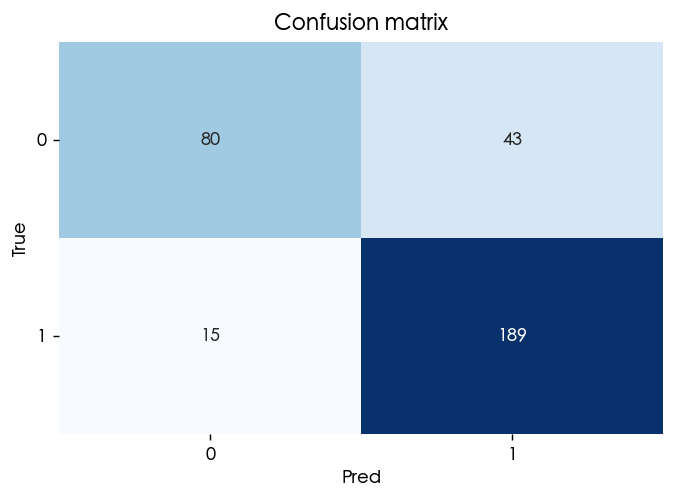

In [25]:
## Make prediction
pred_rf = clf.predict(X_tf[training == 0])

## Build Confusion Marix heat map
classes = np.unique(y)
cm = metrics.confusion_matrix(y[training == 0], pred_rf)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)
plt.show()

##### Model 2: SVM Model

In [57]:
## define hyperparameters and metrics used for grid search
SVM = svm.SVC(probability=True)
param_grid = {
    'C': [0.1, 1, 10, 100, 1000], 
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 'scale', 'auto'],
    'kernel': ['linear', 'sigmoid', 'gaussian', 'rbf']
}

## apply grid search
clf_cv = GridSearchCV(
    SVM, 
    param_grid, 
    cv=5, 
    n_jobs=-1, 
    refit=True, 
    verbose=5
).fit(X_tf[training == 1], y[training == 1])

Fitting 5 folds for each of 140 candidates, totalling 700 fits


In [58]:
## Check the best AUC score and hyperparameters at grid search
print("Best AUC Socre:", clf_cv.best_score_.round(2))
print("---------------------------------------------------------------------")
print("Best Hyperparamters:",clf_cv.best_params_)

Best AUC Socre: 0.83
---------------------------------------------------------------------
Best Hyperparamters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [59]:
## Make prediction on probablities
eval_dat["y_svm"] = 0  # set some initial value
eval_dat["y_svm"] = clf_cv.predict_proba(X_tf)[:, 1]

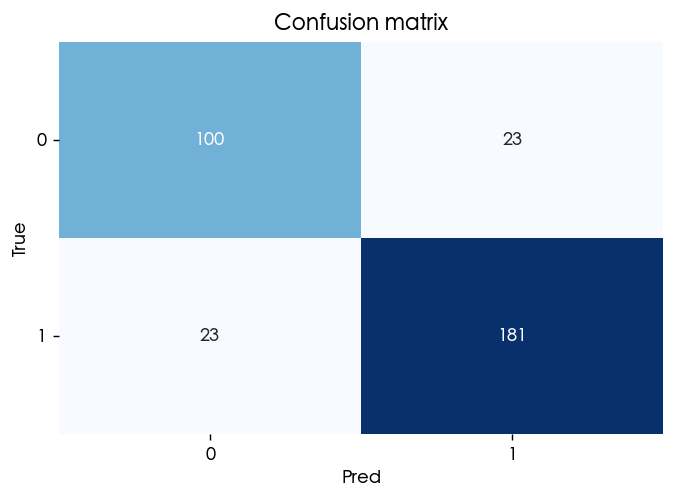

In [60]:
## Make prediction
pred_svm = clf_cv.predict(X_tf[training == 0])

## Build Confusion Marix heat map
classes = np.unique(y)
cm = metrics.confusion_matrix(y[training == 0], pred_svm)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)
plt.show()

##### Model 3: Bert

In [ ]:
# verify GPU availability
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

## Compare Model's Performance

In [61]:
## collect model names that we want to make comparision
model_name = [
    "y_svm",
    "y_rf"
]

## build dictionary to collect data
dct = {
    "training": eval_dat[eval_dat.training == 1],
    "test": eval_dat[eval_dat.training == 0],
}

rsm.evalbin(
    df=dct, 
    rvar=rvar, 
    lev=1, 
    pred=model_name
)\
.drop(['profit', 'index', 'ROME', 'contact'], axis = 1)\
.query("Type == 'test'")\
.sort_values(by="AUC", ascending=False)\
.reset_index(drop=True)

,Type,predictor,TP,FP,TN,FN,total,TPR,TNR,precision,Fscore,accuracy,kappa,AUC
0,test,y_svm,179,21,102,25,327,0.877,0.829,0.895,0.886,0.859,0.702,0.931
1,test,y_rf,189,43,80,15,327,0.926,0.650,0.815,0.867,0.823,0.604,0.910


### Appendix

In [ ]:
stop_words_1 = pd.read_excel('nike_basketball.xlsx', sheet_name = 2, header = None)
stop_words_1 = stop_words_1[0].unique().tolist()

In [ ]:
stop_en = set(stopwords.words('english'))
ps = PorterStemmer() 
removetable = str.maketrans('', '', '\-=~!@#$¥%^&*()_+\[\]{};\'\\:"|<,./<>?（）：`')
tokens_1 = []
tokens_2 = []

for sent in df_clean['SENTENCE'][:3]:
    words = wt(sent) #get words for each sentence
    #words = [ps.stem(word) for word in words]
    tokens_1 += [w.lower() for w in words if w not in stop_en]
for ele in tokens_1:
    tokens_2 += jieba.lcut(ele)
    tokens_2_rem = [s.translate(removetable) for s in tokens_2]
    tokens_2_pro = [w for w in tokens_2_rem if w not in stop_ch]
print(tokens_2_pro)

In [ ]:
## Split data set before building model
X_train, X_test, y_train, y_test = train_test_split(
    bag_of_words, 
    df_clean['RELEVANT'], 
    test_size=0.3, 
    random_state=42, 
    shuffle = True
)

X_test, X_val, y_test, y_val = train_test_split(
    X_test, 
    y_test, 
    test_size=0.5,
    random_state=42, 
    shuffle = True
)

In [ ]:
X.iloc[train_index_val, X.columns == "training_val"] = 1
X.iloc[test_index_val, X.columns == "training_val"] = 2